# Evaluating performance of Geoeffectivenet.

What all do we need for this?

1. A function which takes in the model, dataloader, and generates a bunch of forecasts, target, dates, etc. This function will get us arrays which we can then directly compare and generate predictions.
2. Weimer data loading, forecast loading: Once the top function is done, Weimer forecasts for the same times are loaded. This will also load the weimer forecast at station locations.
3. Generic comparison template: A metric will take target, prediction & give the corresponding metric. 

## Downloading repo and data

Download the repo, data, Weimer data.

## Libraries

Need to initialize imports, etc.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import h5py
from astropy.time import Time
import numpy as np
import glob
import pandas as pd
import re
from datetime import datetime

In [2]:
import dask.dataframe as dd

## Helper functions 

Define some important helper functions to be used later

In [3]:
import sys
sys.path.append('../')
from dataloader import SuperMAGIAGADataset,OMNIDataset,ShpericalHarmonicsDatasetBucketized
from utils.data_utils import get_omni_data,get_iaga_data_as_list
from utils.splitter import generate_indices
from metricgen import EventMetrics,Generate_metrics
from Forecaster import Forecaster,Generate_complete_weimer_forecast,Generate_weimer_forecast
from models.geoeffectivenet import *
import pickle

In [4]:
import matplotlib.colors

class SqueezedNorm(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, mid=0, s1=2, s2=2, clip=False):
        self.vmin = vmin # minimum value
        self.mid  = mid  # middle value
        self.vmax = vmax # maximum value
        self.s1=s1; self.s2=s2
        f = lambda x, zero,vmax,s: np.abs((x-zero)/(vmax-zero))**(1./s)*0.5
        self.g = lambda x, zero,vmin,vmax, s1,s2: f(x,zero,vmax,s1)*(x>=zero) - \
                                             f(x,zero,vmin,s2)*(x<zero)+0.5
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        r = self.g(value, self.mid,self.vmin,self.vmax, self.s1,self.s2)
        return np.ma.masked_array(r)

## Initialize Flags


In [5]:
FLAGS = {}
FLAGS["dataset_dir"]='.'
FLAGS["id"]=''
FLAGS["model"]='NeuralRNNWiemer'
FLAGS["past_omni_length"]=240
FLAGS["past_supermag_length"]=10
FLAGS["future_length"]=1
FLAGS["lag"]=1
FLAGS["skip"]=1
FLAGS["nmax"]=20
FLAGS["batch_size"]=4096
FLAGS["num_epochs"]=10000
FLAGS["save_model_frequency"]=20
FLAGS["learning_rate"]=5e-5
FLAGS["l2reg"] = 1.6e-5
FLAGS["weight_decay"]=0.0
FLAGS['tiny']=False
FLAGS['zero_omni']=False
FLAGS['zero_supermag']=False
FLAGS['plot']=False
FLAGS['validation']=False
FLAGS['targets']='a_nm_dbn_nez'
FLAGS['loss']='MaxSqEr'
FLAGS['scaler']=None
FLAGS["omni_resolution"] = 20
FLAGS['dropout_prob'] = 0.1
FLAGS['n_hidden'] = 64
FLAGS['spherical_path']='../data/spherical_all_stations/spherical_harm_40_maglat_no_intercept/'
FLAGS['year'] = '2015'
FLAGS['iaga_dataset']=f"../data_local/iaga/{FLAGS['year']}/{FLAGS['year']}/"
FLAGS['mhd_dataset']=None
FLAGS["basepath"] = "../MAEBH_2015_OMNI20/"#f"../checkpoints_{int(FLAGS['learning_rate']*1e5)}_{int(FLAGS['batch_size'])}_{int(FLAGS['l2reg']*1e6)}_{FLAGS['nmax']}_{FLAGS['loss']}/"

FLAGS['f107_dataset']='../data_local/f107.npz'
FLAGS['omni_dataset']='../data_local/omni/sw_data.h5'
FLAGS['gridded_loss']=False
FLAGS["ckpts"]=glob.glob(f"{FLAGS['basepath']}/*.ckpt")[0]

In [6]:
glob.glob(f"{FLAGS['basepath']}/*.ckpt")

['../MAEBH_2015_OMNI20/epoch=284-step=25649.ckpt']

In [7]:
future_length = 1 #WAS DEFAULT IN THE CODE
past_omni_length = FLAGS["past_omni_length"]
nmax = FLAGS['nmax']
targets = ["dbe_nez", "dbn_nez"]
lag = FLAGS['lag']
learning_rate = FLAGS["learning_rate"]
batch_size = 2048
omni_resolution = FLAGS["omni_resolution"]
dropout_prob = FLAGS['dropout_prob']
l2reg = FLAGS['l2reg']
n_hidden = FLAGS['n_hidden']

# load scaler to unstandardize data
scalers = pickle.load(open(f"{FLAGS['basepath']}scalers.p", "rb"))
_mean, _std = scalers["supermag"]

dbe_mean, dbn_mean = _mean
dbe_std, dbn_std = _std

In [8]:
scalers

{'omni': StandardScaler(),
 'supermag': [array([ 1.98614274, -7.67701531]),
  array([11.13646527, 17.89744403])]}

## Load the Weimer forecasts

In [9]:
weimer = {}
with h5py.File(f"../data_local/TimeStepGeomagnetic_{FLAGS['year']}0317_1min.h5", "r") as f:
    for k in f.keys():
        weimer[k] = f.get(k)[:]

weimer_times_unix = Time(weimer['JDTIMES'],format='jd').to_value('unix')

### Check the content of npz files

In [46]:
tmp = np.load("../data_local/iaga/2015/2015/supermag_iaga_2015_1.npz",allow_pickle=True)

In [47]:
list(tmp.keys())

['data', 'dates', 'columns', 'stations', 'features']

In [50]:
tmp['features']

array(['MAGLAT', 'MLT', 'dbe_nez', 'dbn_nez', 'ddbe_dt', 'ddbn_dt'],
      dtype='<U7')

## Load data

In [10]:
sg_data = SuperMAGIAGADataset(*get_iaga_data(FLAGS['iaga_dataset']))
omni_data = OMNIDataset(get_omni_data(FLAGS['omni_dataset'], year = FLAGS['year']))

loading supermag iaga data...


  8%|███████                                                                              | 1/12 [00:00<00:04,  2.36it/s]

2015-01-01T00:00:00.000000


 17%|██████████████▏                                                                      | 2/12 [00:00<00:04,  2.46it/s]

2015-02-01T00:00:00.000000


 25%|█████████████████████▎                                                               | 3/12 [00:01<00:03,  2.33it/s]

2015-03-01T00:00:00.000000


 33%|████████████████████████████▎                                                        | 4/12 [00:01<00:03,  2.32it/s]

2015-04-01T00:00:00.000000


 42%|███████████████████████████████████▍                                                 | 5/12 [00:02<00:03,  2.26it/s]

2015-05-01T00:00:00.000000


 50%|██████████████████████████████████████████▌                                          | 6/12 [00:02<00:02,  2.30it/s]

2015-06-01T00:00:00.000000


 58%|█████████████████████████████████████████████████▌                                   | 7/12 [00:03<00:02,  2.29it/s]

2015-07-01T00:00:00.000000


 67%|████████████████████████████████████████████████████████▋                            | 8/12 [00:03<00:01,  2.29it/s]

2015-08-01T00:00:00.000000


 75%|███████████████████████████████████████████████████████████████▊                     | 9/12 [00:03<00:01,  2.32it/s]

2015-09-01T00:00:00.000000


 83%|██████████████████████████████████████████████████████████████████████              | 10/12 [00:04<00:00,  2.32it/s]

2015-10-01T00:00:00.000000


 92%|█████████████████████████████████████████████████████████████████████████████       | 11/12 [00:04<00:00,  2.33it/s]

2015-11-01T00:00:00.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.33it/s]

2015-12-01T00:00:00.000000


In [11]:
wstart = np.argmin(np.abs(weimer_times_unix[0]-sg_data.dates)) - past_omni_length -lag-future_length+2#//2
wend = np.argmin(np.abs(weimer_times_unix[-1]-sg_data.dates))+1 # + future_length//2
weimerinds = np.arange(wstart,wend).astype(int)

In [12]:
weimer_times_unix[0],weimer_times_unix[-1]

(1426564800.0000267, 1426766400.0000403)

In [13]:
sg_data.dates[np.argmin(np.abs(weimer_times_unix[0]-sg_data.dates))],sg_data.dates[wend]

(1426564800.0, 1426766460.0)

In [14]:
print(len(sg_data.features))
dbe_index = np.where(sg_data.features == 'dbe_nez')[0][0]
dbn_index = np.where(sg_data.features == 'dbn_nez')[0][0]
print(dbn_index,dbe_index)

6
3 2


In [15]:
target_index = {'dbe':dbe_index,'dbn':dbn_index}

In [16]:
# wstart = np.argmin(np.abs(weimer_times_unix[0]-sg_data.dates)) - FLAGS['past_omni_length']
# wend = np.argmin(np.abs(weimer_times_unix[-1]-sg_data.dates)) + FLAGS['lag']+FLAGS['future_length']
# weimerinds = np.arange(wstart,wend).astype(int)

# list(range(len(sg_data.dates)))

val_dataset = ShpericalHarmonicsDataset(
        sg_data,
        omni_data,
        weimerinds,
        scaler=scalers,
        targets=targets,
        future_length = future_length,
        past_omni_length=past_omni_length,
        f107_dataset=FLAGS['f107_dataset'],
    )

extracting f107


100%|███████████████████████████████████████████████████████████████████████████████| 3601/3601 [00:04<00:00, 817.39it/s]

using existing scaler


In [17]:
f107 = np.load(FLAGS['f107_dataset'])["dates"]

In [18]:
np.where(f107==np.datetime64(datetime.utcfromtimestamp(sg_data.dates[0]).replace(hour=0, minute=0)))[0][0]

24152

In [19]:
np.argmin(np.abs(f107-np.datetime64(datetime.utcfromtimestamp(sg_data.dates[0]).replace(hour=0, minute=0))))

24152

Text(0, 0.5, 'dbn_nez')

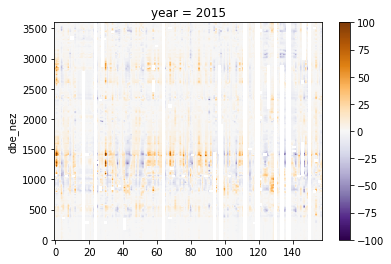

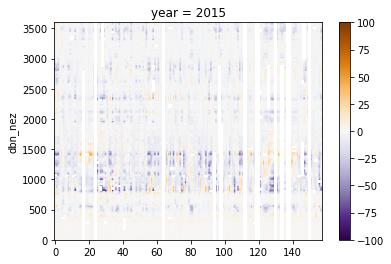

In [28]:
plt.imshow(val_dataset.supermag_data[:,:,2],cmap='PuOr_r',origin='lower',aspect='auto',clim=(-100,100))
plt.colorbar()
plt.title(f"year = {FLAGS['year']}")
plt.ylabel(val_dataset.supermag_features[2])
plt.figure()
plt.imshow(val_dataset.supermag_data[:,:,3],cmap='PuOr_r',origin='lower',aspect='auto',clim=(-100,100))
plt.colorbar()
plt.title(f"year = {FLAGS['year']}")
plt.ylabel(val_dataset.supermag_features[3])

Text(0, 0.5, 'dbn_nez')

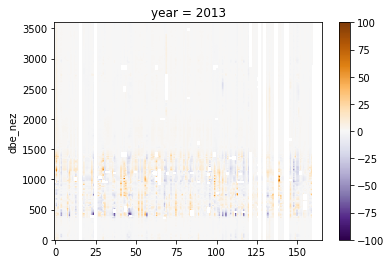

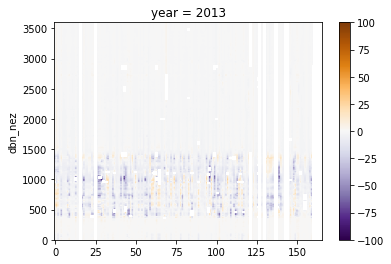

In [89]:
plt.imshow(val_dataset.supermag_data[:,:,2],cmap='PuOr_r',origin='lower',aspect='auto',clim=(-100,100))
plt.colorbar()
plt.title(f"year = {FLAGS['year']}")
plt.ylabel(val_dataset.supermag_features[2])
plt.figure()
plt.imshow(val_dataset.supermag_data[:,:,3],cmap='PuOr_r',origin='lower',aspect='auto',clim=(-100,100))
plt.colorbar()
plt.title(f"year = {FLAGS['year']}")
plt.ylabel(val_dataset.supermag_features[3])

In [20]:
print(sg_data.data.shape,weimer['DB'].shape)
print(sg_data.data[weimerinds[0]].shape, weimer['DB'][0].shape)
print("------------------------")
ind = 500
tmpsupermag = sg_data.data[weimerinds[ind],:,3]
tmpweimer = weimer['DB'][ind,0].ravel()
print(np.nanmax(tmpsupermag),np.nanmin(tmpsupermag),np.nanmean(tmpsupermag))
print(np.nanmax(tmpweimer),np.nanmin(tmpweimer),np.nanmean(tmpweimer))

(525600, 158, 6) (3361, 3, 100, 96)
(158, 6) (3, 100, 96)
------------------------
227.1 -768.9 -102.7048275862069
255.04115 -393.9575 -9.567321


In [21]:
targets_idx = [np.where(val_dataset.supermag_features == target)[0][0] for target in targets]

In [22]:
from torch.utils import data
validation_loader = data.DataLoader(val_dataset,
                                    batch_size=128,
                                    shuffle=False)

## Get the Weimer basis

In [23]:
print(weimer.keys())
weimer_mlt = np.deg2rad(90-weimer['GRIDMLTS']*360/24.0)
weimer_colat = np.deg2rad(90 - weimer['GRIDLATS'])
weimer_basis = basis_matrix(FLAGS["nmax"] ,weimer_mlt, weimer_colat)
weimer_shape = weimer['GRIDMLTS'].shape


dict_keys(['DB', 'GRIDLATS', 'GRIDMLTS', 'JDTIMES', 'LATITUDES', 'MLTVALS'])


## Load Model

In [24]:
model = NeuralRNNWiemer.load_from_checkpoint(f'{FLAGS["ckpts"]}', strict=False, 
                                                 past_omni_length=past_omni_length,
                                                 future_length=future_length,
                                                 supermag_features=val_dataset.supermag_features,
                                                 omni_features=val_dataset.omni_features,
                                                 nmax=nmax,omni_resolution=omni_resolution,
                                                 targets_idx=targets_idx,learning_rate = learning_rate,
                                                 l2reg=l2reg,
                                                 dropout_prob=dropout_prob,
                                                 n_hidden=n_hidden,
                                                 loss=FLAGS['loss'])

Constructing spherical harmonics functions


In [25]:
model = model.cuda().double()

## Generate Forecasts 

### FDL model forecasts

In [26]:
Predictions,Targets,All_times_coeff,Date_arr,MLT_sup_all,Mcolat_sup_all = Forecaster(validation_loader,model,dbe_mean,dbe_std,dbn_mean,dbn_std,target_index)

### Weimer forecasts on supermag

In [27]:
Date_arr['dbe'][0]-weimer_times_unix[0]

array([-2.67028809e-05])

In [28]:
weimer['DB'][:,1].shape,MLT_sup_all['dbe'].shape,Mcolat_sup_all['dbe'].shape, Predictions['dbe'].shape

((3361, 100, 96), (3361, 158), (3361, 158), (3361, 158))

In [29]:
prediction_weimer_dbn = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,0],
                                                          MLT_sup_all['dbn'],Mcolat_sup_all['dbn'])
prediction_weimer_dbe = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,1],
                                                          MLT_sup_all['dbe'],Mcolat_sup_all['dbe'])

### Generate metrics

In [30]:
fdl_metrics_dbe = Generate_metrics(Targets['dbe'],Predictions['dbe'])
fdl_metrics_dbn = Generate_metrics(Targets['dbn'],Predictions['dbn'])

weimer_metrics_dbe = Generate_metrics(Targets['dbe'],prediction_weimer_dbn)
weimer_metrics_dbn = Generate_metrics(Targets['dbn'],prediction_weimer_dbe)

In [31]:
print(f"FDL dbe:{fdl_metrics_dbe}")
print(f"Weimer dbe:{weimer_metrics_dbe}")
print("--------------------")
print(f"FDL dbn: {fdl_metrics_dbn}")
print(f"Weimer dbn: {weimer_metrics_dbn}")

FDL dbe:{'mse': 113.32084683898229, 'mae': 62.69930522699087, 'r2': -0.23795476677659422}
Weimer dbe:{'mse': 180.2153186510187, 'mae': 105.32366373535467, 'r2': -2.562549289289255}
--------------------
FDL dbn: {'mse': 155.97453818445607, 'mae': 96.90348651857879, 'r2': -0.4288795474946088}
Weimer dbn: {'mse': 195.44405906168586, 'mae': 121.36011203644296, 'r2': -0.6620173845100205}


In [32]:
eventmets_fdl = EventMetrics(Targets['dbe'],Targets['dbn'],Predictions['dbe'],Predictions['dbn'])
eventmets_weimer = EventMetrics(Targets['dbe'],Targets['dbn'],prediction_weimer_dbe,prediction_weimer_dbn)

(20, 1)
(20, 1)
(20, 1)
(20, 1)


/home/uvishal/data/geoeffectivenet/Benchmark/metricgen.py:58: RuntimeWarning: invalid value encountered in true_divide
  pod = tmpconf['hits']/(tmpconf['hits']+tmpconf['misses'])
/home/uvishal/data/geoeffectivenet/Benchmark/metricgen.py:61: RuntimeWarning: invalid value encountered in true_divide
  hss = hss/((tmpconf['hits']+tmpconf['misses'])*(tmpconf['misses']+tmpconf['truenegative'])+(tmpconf['hits']+tmpconf['falsealarm'])*(tmpconf['falsealarm']+tmpconf['truenegative']))


In [33]:
for thresh in eventmets_fdl.keys():
  print(f"Threshold: {thresh}")
  for k in eventmets_fdl[thresh].keys():
    print(f"FDL {k}:{np.nanmean(eventmets_fdl[thresh][k])}+/-{np.nanstd(eventmets_fdl[thresh][k])}")
    print(f"Weimer {k}:{np.nanmean(eventmets_weimer[thresh][k])}+/-{np.nanstd(eventmets_weimer[thresh][k])}")
    print("------------")
  print("******************************************")

Threshold: 0.3
FDL pod:0.9338705617874205+/-0.07174711611627065
Weimer pod:0.11121479215136897+/-0.0764389712980988
------------
FDL pofd:0.6585890197822067+/-0.27618046417170994
Weimer pofd:0.041945315738089274+/-0.038420694466763924
------------
FDL hss:0.13543631602942272+/-0.16190800231331884
Weimer hss:0.06021238310381986+/-0.07070878672117753
------------
******************************************
Threshold: 0.7
FDL pod:0.8535667471990763+/-0.12785112751262628
Weimer pod:0.02164460701642858+/-0.035479810274162034
------------
FDL pofd:0.4251409024757112+/-0.21799405895070523
Weimer pofd:0.010369533531894726+/-0.011235514072543086
------------
FDL hss:0.14220574830340388+/-0.13570820616845644
Weimer hss:0.01219979234841534+/-0.048188233339943216
------------
******************************************
Threshold: 1.1
FDL pod:0.7131101127015511+/-0.25986559052309394
Weimer pod:0.009410897354504549+/-0.027287738622176087
------------
FDL pofd:0.2974677902758508+/-0.16966620072089192
W

In [42]:
for thresh in eventmets_fdl.keys():
    print(f"Threshold: {thresh}")
    for k in eventmets_fdl[thresh].keys():
        print(f"FDL {k}:{np.nanmean(eventmets_fdl[thresh][k])}+/-{np.nanstd(eventmets_fdl[thresh][k])}")
        print(f"Weimer {k}:{np.nanmean(eventmets_weimer[thresh][k])}+/-{np.nanstd(eventmets_weimer[thresh][k])}")
        print("------------")
    print("******************************************")

Threshold: 0.3
FDL pod:0.9531176929522109+/-0.0741432497997015
Weimer pod:0.11121479215136897+/-0.0764389712980988
------------
FDL pofd:0.7153331795700691+/-0.26975954097162697
Weimer pofd:0.041945315738089274+/-0.038420694466763924
------------
FDL hss:0.11218410039310575+/-0.15139502955857956
Weimer hss:0.06021238310381986+/-0.07070878672117753
------------
******************************************
Threshold: 0.7
FDL pod:0.9455323445057012+/-0.04945449234513253
Weimer pod:0.02164460701642858+/-0.035479810274162034
------------
FDL pofd:0.48163709152460416+/-0.27284971525697027
Weimer pofd:0.010369533531894726+/-0.011235514072543086
------------
FDL hss:0.1477857481873499+/-0.13173105774799476
Weimer hss:0.01219979234841534+/-0.048188233339943216
------------
******************************************
Threshold: 1.1
FDL pod:0.8874455772758524+/-0.1293053867849611
Weimer pod:0.009410897354504549+/-0.027287738622176087
------------
FDL pofd:0.35265478779303766+/-0.21920968195955962
We

## Check plots

In [34]:
Targets['dbe'].shape,Predictions['dbe'].shape,prediction_weimer_dbn.shape

((3361, 158), (3361, 158), (3361, 158))

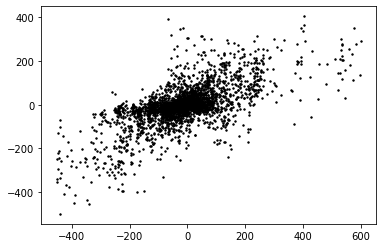

In [35]:
plt.scatter(Targets['dbe'][:,100],Predictions['dbe'][:,100],s=2.0,c='k')
# plt.scatter(Targets['dbe'].ravel(),prediction_weimer_dbe.ravel(),s=2.0,c='b')

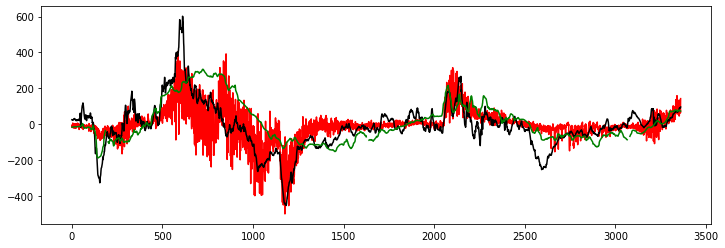

In [36]:
plt.figure(figsize=(12,4))
plt.plot(Predictions['dbe'][:,100],'r')
plt.plot(Targets['dbe'][:,100],'k')
plt.plot(prediction_weimer_dbe[:,100],'g')

Text(0, 0.5, 'dbn pred')

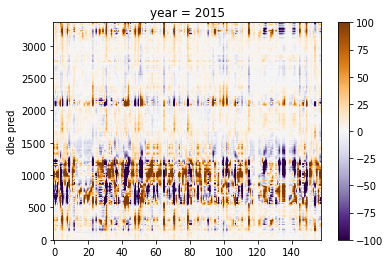

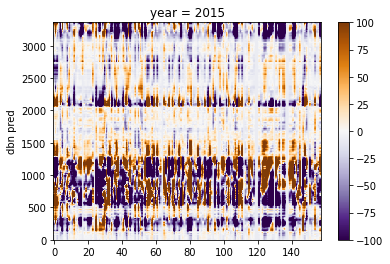

In [37]:
plt.imshow(Predictions['dbe'],cmap='PuOr_r',origin='lower',aspect='auto',clim=(-100,100))
plt.colorbar()
plt.title(f"year = {FLAGS['year']}")
plt.ylabel("dbe pred")
plt.figure()
plt.imshow(Predictions['dbn'],cmap='PuOr_r',origin='lower',aspect='auto',clim=(-100,100))
plt.colorbar()
plt.title(f"year = {FLAGS['year']}")
plt.ylabel("dbn pred")

In [120]:
prediction_weimer_dbn[:,130]

array([nan, nan, nan, ..., nan, nan, nan])

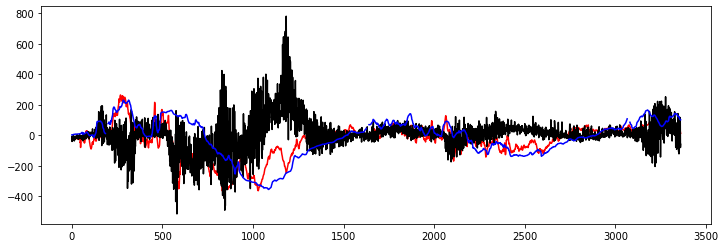

In [39]:
plt.figure(figsize=(12,4))
plt.plot(Targets['dbn'][:,100],'r')
plt.plot(Predictions['dbn'][:,100],'k')
plt.plot(prediction_weimer_dbn[:,100],'b')

In [40]:
All_times_coeff['dbn'].shape

(3361, 882)

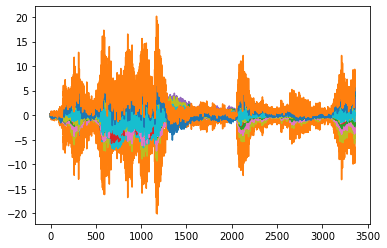

In [41]:
plt.plot(All_times_coeff['dbn'])

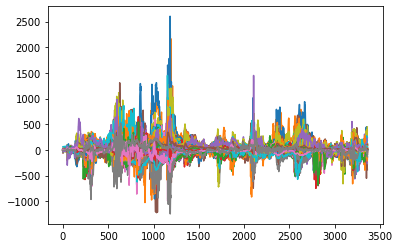

In [42]:
plt.plot(Targets['dbe'])

# Check residuals

Text(0, 0.5, 'target - pred')

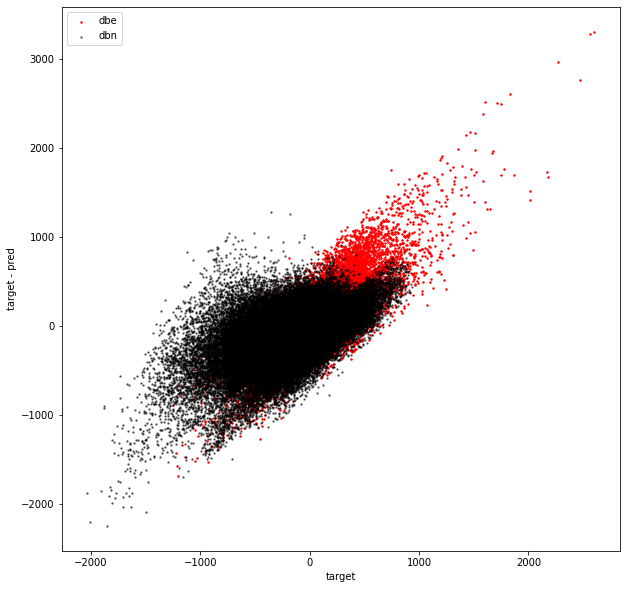

In [43]:
plt.figure(figsize=(10,10))
res_dbn = Targets['dbn']-Predictions['dbn']
res_dbe = Targets['dbe']-Predictions['dbe']
plt.scatter(Targets['dbe'].ravel(),res_dbe.ravel(),c='r',s=2.0,label='dbe')
plt.scatter(Targets['dbn'].ravel(),res_dbn.ravel(),c='k',s=2.0,label='dbn',alpha=0.5)
plt.legend(loc='best')
plt.xlabel('target')
plt.ylabel('target - pred')

## Data loader check

In [44]:
for past_omni, past_supermag, future_supermag, past_dates, future_dates, (mlt, mcolat) in validation_loader:
    print(past_supermag.shape)

torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([128, 10, 158, 6])
torch.Size([33, 10, 158, 6])


## FDL forecast on weimer grid

In [ ]:
weimer_predictions_gif = {'dbe':[],'dbn':[]}
fdl_on_weimergrid_gif = {'dbe':[],'dbn':[]}

fdl_on_weimergrid_gif['dbn'] = np.einsum('bij,lj->bil',weimer_basis,All_times_coeff['dbn'])
fdl_on_weimergrid_gif['dbe'] = np.einsum('bij,lj->bil',weimer_basis,All_times_coeff['dbe'])

fdl_on_weimergrid_gif['dbn'] = fdl_on_weimergrid_gif['dbn']*dbn_std + dbn_mean
fdl_on_weimergrid_gif['dbe'] = fdl_on_weimergrid_gif['dbe']*dbe_std + dbe_mean

weimer_predictions_gif['dbn'] = weimer['DB'][:, 0]
weimer_predictions_gif['dbe'] = weimer['DB'][:, 1]

print(fdl_on_weimergrid_gif['dbn'].shape,weimer_predictions_gif['dbn'].shape)


(100, 96, 3361) (3361, 100, 96)


In [1]:
!pip install celluloid

In [ ]:
from celluloid import Camera

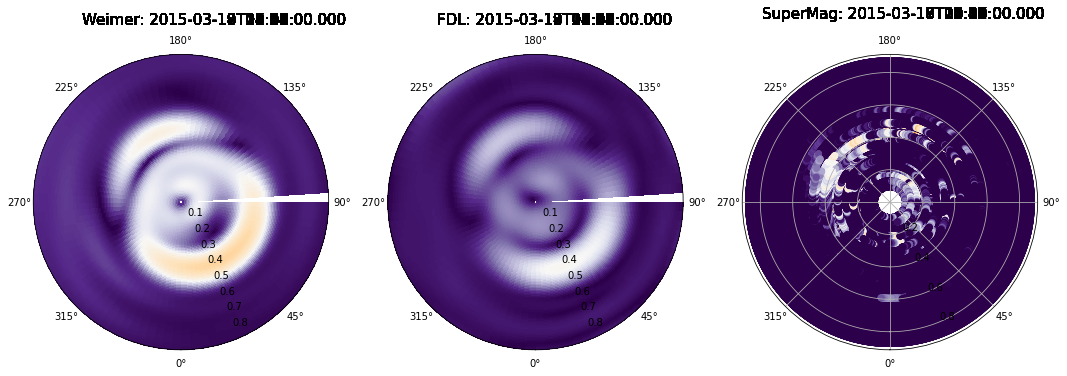

In [ ]:
 
k = 'dbn'
fig1 = plt.figure(figsize=(18,6))
camera = Camera(fig1)
theta = weimer_mlt 
phi = weimer_colat 
cmap='PuOr_r'
ax1 = fig1.add_subplot(131, projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(132, projection='polar')
ax2.set_theta_offset(-np.pi/2)
ax3 = fig1.add_subplot(133, projection='polar')
ax3.set_theta_offset(-np.pi/2)
for time_ind,d in enumerate(weimer['JDTIMES']):
  dt = Time(d,format='jd').to_value("fits")
  dbH = np.sqrt(np.square(Targets['dbn'][time_ind])+np.square(Targets['dbe'][time_ind]))
  maxval=np.nanmax(dbH)
  minval=np.nanmin(dbH)
  norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=np.nanmean(dbH), s1=1, s2=1)

  dbH = np.sqrt(np.square(weimer_predictions_gif['dbe'][time_ind])+np.square(weimer_predictions_gif['dbn'][time_ind]))
  c1=ax1.pcolormesh(theta,phi,dbH ,cmap=cmap,norm=norm)
  ax1.text(3.65,1.2,f"Weimer: {dt}",fontsize=15)

  dbH = np.sqrt(np.square(fdl_on_weimergrid_gif['dbe'][...,time_ind])+np.square(fdl_on_weimergrid_gif['dbn'][...,time_ind]))
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)  
  ax2.text(3.65,1.2,f"FDL: {dt}",fontsize=15)

  dbH = np.sqrt(np.square(Mcolat_sup_all['dbe'][time_ind])+np.square(Mcolat_sup_all['dbn'][time_ind]))
  c3=ax3.scatter(MLT_sup_all[k][time_ind],Mcolat_sup_all[k][time_ind], c=Targets[k][time_ind],cmap=cmap,norm=norm)
  ax3.text(3.75,1.38,f"SuperMag: {dt}",fontsize=15)
  camera.snap()

In [ ]:
from IPython.display import HTML
animation = camera.animate()
HTML(animation.to_html5_video())

Animation movie is 34047933 bytes, exceeding the limit of 20971520.0. If you're sure you want a large animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB).


In [ ]:
animation.save('dbH.mp4')

In [ ]:
 
k = 'dbe'
fig1 = plt.figure(figsize=(18,6))
# camera = Camera(fig1)
theta = weimer_mlt 
phi = weimer_colat 
cmap='PuOr_r'
ax1 = fig1.add_subplot(131, projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(132, projection='polar')
ax2.set_theta_offset(-np.pi/2)
ax3 = fig1.add_subplot(133, projection='polar')
ax3.set_theta_offset(-np.pi/2)
for time_ind,d in enumerate(weimer['JDTIMES'][:2]):
  dt = Time(d,format='jd').to_value("fits")

  maxval=np.nanmax(Targets[k][time_ind])
  minval=np.nanmin(Targets[k][time_ind])
  norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=0, s1=2, s2=2)

  c1=ax1.pcolormesh(theta,phi, weimer_predictions_gif[k][time_ind],cmap=cmap,norm=norm)
  ax1.text(3.65,1.2,f"Weimer: {dt}",fontsize=15)

  c2=ax2.pcolormesh(theta,phi, fdl_on_weimergrid_gif[k][...,time_ind],cmap=cmap,norm=norm)  
  ax2.text(3.65,1.2,f"FDL: {dt}",fontsize=15)

  c3=ax3.scatter(MLT_sup_all[k][time_ind],Mcolat_sup_all[k][time_ind], c=Targets[k][time_ind],cmap=cmap,norm=norm)
  ax3.text(3.75,1.38,f"SuperMag: {dt}",fontsize=15)
  # camera.snap()

In [ ]:
 
k = 'dbn'
fig1 = plt.figure(figsize=(18,6))
camera = Camera(fig1)
theta = weimer_mlt 
phi = weimer_colat 
cmap='PuOr_r'
ax1 = fig1.add_subplot(131, projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(132, projection='polar')
ax2.set_theta_offset(-np.pi/2)
ax3 = fig1.add_subplot(133, projection='polar')
ax3.set_theta_offset(-np.pi/2)
for time_ind,d in enumerate(weimer['JDTIMES'][::2]):
  dt = Time(d,format='jd').to_value("fits")

  maxval=np.nanmax(Targets[k][time_ind])
  minval=np.nanmin(Targets[k][time_ind])
  norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=0, s1=2, s2=2)

  c1=ax1.pcolormesh(theta,phi, weimer_predictions_gif[k][time_ind],cmap=cmap,norm=norm)
  ax1.text(3.65,1.2,f"Weimer: {dt}",fontsize=15)

  c2=ax2.pcolormesh(theta,phi, fdl_on_weimergrid_gif[k][...,time_ind],cmap=cmap,norm=norm)  
  ax2.text(3.65,1.2,f"FDL: {dt}",fontsize=15)

  c3=ax3.scatter(MLT_sup_all[k][time_ind],Mcolat_sup_all[k][time_ind], c=Targets[k][time_ind],cmap=cmap,norm=norm)
  ax3.text(3.75,1.38,f"SuperMag: {dt}",fontsize=15)
  camera.snap()
  
# cb= fig1.colorbar(c1, shrink=0.5)
# cb.set_label(k,fontsize=15)
# cb= fig1.colorbar(c2, shrink=0.5)
# cb.set_label(k,fontsize=15)
# cb= fig1.colorbar(c3, shrink=0.5)
# cb.set_label(k,fontsize=15)